In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols

from mri_data import file_manager as fm

In [2]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary_FLAIR-1"

## Data Cleaning

Load volume dataset

In [3]:
df_vols = pd.read_csv(curr_dir / "clinical_data_full.csv")
df_vols = df_vols.set_index("subid")
keep_cols = ["choroid_volume", "pineal_volume", "pituitary_volume", "tiv", "flair_contrast", "label", "scan_folder", "age"]

not_nas = (~df_vols['pineal_volume'].isna() & ~df_vols['choroid_volume'].isna() & ~df_vols['pituitary_volume'].isna())
df_vols = df_vols.loc[not_nas, keep_cols]

In [4]:
def subject_to_subid(subject):
    if not isinstance(subject, str):
        return None
    re_match = re.match(r"ms(\d{4})", subject)
    if re_match:
        return_val = int(re_match[1])
        return return_val
    else:
        return None

In [5]:
df_full = pd.read_csv(msmri_datadir / "Clinical_Data_All_updated.csv")
df_full.insert(0, "subid", df_full['ID'].map(subject_to_subid))
df_full = df_full.set_index("subid")

df = pd.merge(df_vols, df_full.loc[:, ~df_full.columns.isin(df_vols.columns)], how='outer', on='subid')

df.loc[:, 'extracted_EDSS'] = [float(val) if val != "." else None for val in df['extracted_EDSS']] #! figure out what to do with "."
df.loc[:, ['EDSS']] = pd.Categorical(df['extracted_EDSS'], ordered=True)
df.loc[df['PRL'] == "#VALUE!", 'PRL'] = None
df.loc[:, 'PRL'] = [int(val) if val != "#VALUE!" and val is not None else None for val in df['PRL']]
df.loc[df['dzdur'] == "#VALUE!", "dzdur"] = None

In [6]:
prl_levels = [range(0,1), range(1,3), range(3,5), range(5,df['PRL'].max()+1)]
df.loc[:, ['PRL_LEVEL']] = None
for i, level in enumerate(prl_levels):
    df.loc[df['PRL'].isin(level), ['PRL_LEVEL']] = i
df.loc[:, ['PRL_LEVEL']] = pd.Categorical(df['PRL_LEVEL'], ordered=True)

In [7]:
def check_nind(subtype):
    if "migraine" in subtype:
        return True
    elif "IIH" in subtype:
        return True
    elif "Migraine" in subtype:
        return True
    else:
        return False

In [8]:
def check_nind2(subtype):
    if type(subtype) is not str:
        return False
    keywords = ["migraine", "IIH", "anxiety", "Migraine"]
    for word in keywords:
        if word in subtype:
            return True
    return False

Add columns for volumes normalized by TIV

In [9]:
df.loc[:, ['norm_choroid_volume']] = df['choroid_volume']/df['tiv']
df.loc[:, ['norm_pineal_volume']] = df['pineal_volume']/df['tiv']
df.loc[:, ['norm_pituitary_volume']] = df['pituitary_volume']/df['tiv']

### Categorize Disease Types

- RMS vs MS vs !MS
- MS vs !MS
- MS vs OIND vs NIND

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [10]:
try:
    df.insert(18, 'dz_type', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df.loc[df['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'
# df.loc[(df['dz_type'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type"] = "HC"
print(df['dz_type'].unique())
print(sum(df['dz_type'] == "HC"))

['RMS' 'PMS' '!MS' 'UNK' 'RIS']
0


`dz_type2` has MS versus !MS and UNK

In [11]:
try:
    df.insert(18, 'dz_type2', df['dz_type'])
except Exception:
    pass

df.loc[:, 'dz_type2'] = df['dz_type']

df.loc[df['dz_type'].isin(['RMS', 'PMS']), 'dz_type2'] = 'MS'
df['dz_type2'].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [12]:
try:
    df.insert(18, 'dz_type3', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type3'] = df['ms_type']

df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS', 'RRMS', 'CIS']), 'dz_type3'] = 'MS'
df['dz_type3'].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

`dz_type4`

In [13]:
try:
    df.insert(18, 'dz_type4', df['dz_type3'])
except Exception:
    pass

df.loc[:, 'dz_type4'] = df['dz_type3']

df.loc[(df['dz_type4'] == "NIND") & (df.loc[:, 'subtype'].map(check_nind2)), "dz_type4"] = "HC"

`dz_type5`

In [14]:
try:
    df.insert(18, 'dz_type5', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type5'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type5'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type5'] = 'PMS'
# df.loc[(df['dz_type5'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type5"] = "HC"
print(df['dz_type5'].unique())

['RMS' 'PMS' 'NIND' 'UNK' 'HC' 'OIND' 'RIS']


## Descriptive Stats

In [15]:
print(len(df), "patients in total")
nRMS = sum(df['dz_type'] == "RMS")
nPMS = sum(df['dz_type'] == "PMS")
nNotMS = sum(df['dz_type'] == "!MS")
print(nRMS, "patients with RMS", f"({round(nRMS / len(df), 2)})")
print(nPMS, "patients with PMS", f"({round(nPMS / len(df), 2)})")
print(nNotMS, "patients w/o MS", f"({round(nNotMS / len(df), 2)})")

564 patients in total
368 patients with RMS (0.65)
97 patients with PMS (0.17)
92 patients w/o MS (0.16)


In [16]:
print(len(df), "patients in total")
nMS = sum(df['dz_type3'] == "MS")
nOIND = sum(df['dz_type3'] == "OIND")
nNIND = sum(df['dz_type3'] == "NIND")
print(nMS, "patients with MS", f"({round(nMS / len(df), 2)})")
print(nOIND, "patients with OIND", f"({round(nOIND / len(df), 2)})")
print(nNIND, "patients w/o NIND", f"({round(nNIND / len(df), 2)})")

564 patients in total
465 patients with MS (0.82)
41 patients with OIND (0.07)
49 patients w/o NIND (0.09)


In [17]:
print("Female subjects:     {:0.2f}".format(sum(df['sex'] == "Female") / len(df)) )
print("Average age at scan: {:0.2f}".format(df['age'].mean()))

Female subjects:     0.79
Average age at scan: 47.73


In [18]:
df_rrms = df.loc[df["dz_type"] == "RMS"]
print("RMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_rrms['sex'] == "Female") / len(df_rrms)))
print("\tAge:     {:0.2f}".format(df_rrms['age'].mean()))

df_pms = df.loc[df["dz_type"] == "PMS"]
print("PMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_pms['sex'] == "Female") / len(df_pms)))
print("\tAge:     {:0.2f}".format(df_pms['age'].mean()))

df_notms = df.loc[df["dz_type"] == "!MS"]
print("!MS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_notms['sex'] == "Female") / len(df_notms)))
print("\tAge:     {:0.2f}".format(df_notms['age'].mean()))

RMS Patients:
	Female:  0.84
	Age:     44.55
PMS Patients:
	Female:  0.59
	Age:     58.30
!MS Patients:
	Female:  0.82
	Age:     49.57


#### Volumes

In [19]:
# choroid
print("Choroid volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['choroid_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['choroid_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['choroid_volume'].mean()))

# pineal
print("Pineal volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pineal_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pineal_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pineal_volume'].mean()))

# pituitary
print("Pituitary volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms['pituitary_volume'].mean()))
print("\tPMS:    {:0.2f}".format(df_pms['pituitary_volume'].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms['pituitary_volume'].mean()))

Choroid volumes:
	RRMS:   1927.14
	PMS:    2203.40
	not-MS: 1960.97
Pineal volumes:
	RRMS:   237.07
	PMS:    217.64
	not-MS: 263.39
Pituitary volumes:
	RRMS:   722.91
	PMS:    729.09
	not-MS: 712.19


In [20]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type2'] == "MS"].choroid_volume.mean()
choroid_notms_mean = df[df['dz_type2'] == "!MS"].choroid_volume.mean()
print("\tMS:     {:0.2f}".format(choroid_ms_mean))
print("\tnot-MS: {:0.2f}".format(choroid_notms_mean))

print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_notms_mean = df[df['dz_type2'] == "!MS"].pineal_volume.mean()
print("\tMS:     {:0.2f}".format(pineal_ms_mean))
print("\tnot-MS: {:0.2f}".format(pineal_notms_mean))

print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_notms_mean = df[df['dz_type2'] == "!MS"].pituitary_volume.mean()
print("\tMS:     {:0.2f}".format(pituitary_ms_mean))
print("\tnot-MS: {:0.2f}".format(pituitary_notms_mean))

Choroid volumes:
	MS:     1984.93
	not-MS: 1960.97

Pineal volumes
	MS:     233.01
	not-MS: 263.39

Pituitary volumes
	MS:     724.20
	not-MS: 712.19


In [ ]:
print("Choroid volumes:")
choroid_ms_mean = df[df['dz_type3'] == "MS"].choroid_volume.mean()
choroid_oind_mean = df[df['dz_type3'] == "OIND"].choroid_volume.mean()
choroid_nind_mean = df[df['dz_type3'] == "NIND"].choroid_volume.mean()
print("\tMS:   {:0.2f}".format(choroid_ms_mean))
print("\tOIND: {:0.2f}".format(choroid_oind_mean))
print("\tNIND: {:0.2f}".format(choroid_nind_mean))


print("\nPineal volumes")
pineal_ms_mean = df[df['dz_type2'] == "MS"].pineal_volume.mean()
pineal_oind_mean = df[df['dz_type3'] == "OIND"].pineal_volume.mean()
pineal_nind_mean = df[df['dz_type3'] == "NIND"].pineal_volume.mean()
print("\tMS:   {:0.2f}".format(pineal_ms_mean))
print("\tOIND: {:0.2f}".format(pineal_oind_mean))
print("\tNIND: {:0.2f}".format(pineal_nind_mean))


print("\nPituitary volumes")
pituitary_ms_mean = df[df['dz_type2'] == "MS"].pituitary_volume.mean()
pituitary_oind_mean = df[df['dz_type3'] == "OIND"].pituitary_volume.mean()
pituitary_nind_mean = df[df['dz_type3'] == "NIND"].pituitary_volume.mean()
print("\tMS:   {:0.2f}".format(pituitary_ms_mean))
print("\tOIND: {:0.2f}".format(pituitary_oind_mean))
print("\tNIND: {:0.2f}".format(pituitary_nind_mean))

Choroid volumes:
	MS:   1984.93
	OIND: 2013.21
	NIND: 1940.35

Pineal volumes
	MS:   233.01
	OIND: 236.75
	NIND: 287.80

Pituitary volumes
	MS:   724.20
	OIND: 729.93
	NIND: 698.48


## Plots

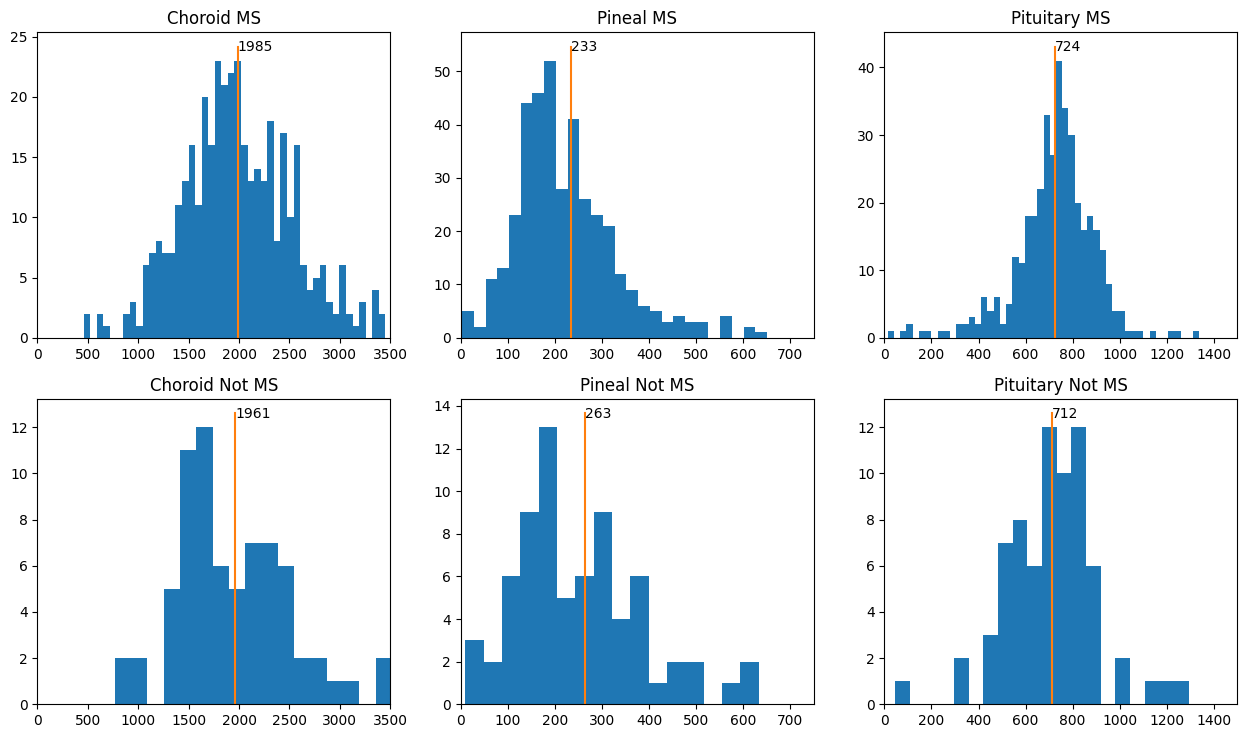

In [22]:
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df.loc[df['dz_type2']=='MS', 'choroid_volume'], bins=50)
ax[0,0].set_xlim([0, 3500])
ax[0,0].set_title("Choroid MS")
ax[0,0].plot([choroid_ms_mean, choroid_ms_mean], ax[0,0].get_ylim())
text_y = ax[0,0].get_ylim()[1] - ax[0,0].get_ylim()[1] / 16
ax[0,0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df['dz_type2']=='!MS', 'choroid_volume'], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1,0].plot([choroid_notms_mean, choroid_notms_mean], ax[1,0].get_ylim())
text_y = ax[1,0].get_ylim()[1] - ax[1,0].get_ylim()[1] / 16
ax[1,0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0,1].hist(df.loc[df['dz_type2']=='MS', 'pineal_volume'], bins=50)
ax[0,1].set_xlim([0, 750])
ax[0,1].set_title("Pineal MS")
ax[0,1].plot([pineal_ms_mean, pineal_ms_mean], ax[0,1].get_ylim())
text_y = ax[0,1].get_ylim()[1] - ax[0,1].get_ylim()[1] / 16
ax[0,1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1,1].hist(df.loc[df['dz_type2']=='!MS', 'pineal_volume'], bins=30)
ax[1,1].set_xlim([0, 750])
ax[1,1].set_title("Pineal Not MS")
ax[1,1].plot([pineal_notms_mean, pineal_notms_mean], ax[1,1].get_ylim())
text_y = ax[1,1].get_ylim()[1] - ax[1,1].get_ylim()[1] / 16
ax[1,1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0,2].hist(df.loc[df['dz_type2']=='MS', 'pituitary_volume'], bins=50)
ax[0,2].set_xlim([0, 1500])
ax[0,2].set_title("Pituitary MS")
ax[0,2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0,2].get_ylim())
text_y = ax[0,2].get_ylim()[1] - ax[0,2].get_ylim()[1] / 16
ax[0,2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1,2].hist(df.loc[df['dz_type2']=='!MS', 'pituitary_volume'], bins=20)
ax[1,2].set_xlim([0, 1500])
ax[1,2].set_title("Pituitary Not MS")
ax[1,2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1,2].get_ylim())
text_y = ax[1,2].get_ylim()[1] - ax[1,2].get_ylim()[1] / 16
ax[1,2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

## Regression Models

Covariates: age, sex, TIV, contrast

### Linear Regression on Volume

Predict volume of structure with the following predictors:

- MS vs Not-MS
- MS vs OIND vs NIND
- RMS vs PMS

#### Choroid Plexus

##### MS vs not-MS

In [23]:
volume = 'choroid_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     23.11
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           2.06e-17
Time:                        12:39:18   Log-Likelihood:                -3538.0
No. Observations:                 463   AIC:                             7086.
Df Residuals:                     458   BIC:                             7107.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           12.2378      1.897      6.450      0.0

##### MS vs NIND vs OIND

In [24]:
volume = 'choroid_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     22.74
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           4.85e-17
Time:                        12:39:18   Log-Likelihood:                -3292.7
No. Observations:                 431   AIC:                             6595.
Df Residuals:                     426   BIC:                             6616.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           12.8213      1.957      6.553      0.0

##### PMS v RMS

In [28]:
volume = 'choroid_volume'

data = df[['dz_type5', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type5'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type5']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'intercept']
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     15.42
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           4.02e-16
Time:                        14:09:16   Log-Likelihood:                -3522.8
No. Observations:                 461   AIC:                             7060.
Df Residuals:                     454   BIC:                             7089.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           11.3517      2.074      5.473      0.0

Alternative to dummy coding, using R style formula

In [34]:
volume = 'choroid_volume'

data = df[['dz_type5', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type5'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data['sex_male'] = data.sex.map({'Female': 0, 'Male': 1})

fit = ols('volume ~ C(sex_male) + C(dz_type5) + C(flair_contrast) + age + tiv', data=data).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     17.83
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           6.21e-21
Time:                        12:48:28   Log-Likelihood:                -3509.5
No. Observations:                 461   AIC:                             7035.
Df Residuals:                     453   BIC:                             7068.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [31]:
volume = 'choroid_volume'

data = df[['dz_type4', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, "PRL_LEVEL", "lesion_vol_cubic"]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type4'].isin(['MS', 'HC'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type4']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

# predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']
predictors = ['age', 'Female', 'tiv', 'MS', 'lesion_vol_cubic', 'PRL_LEVEL', 'intercept']
res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     17.33
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           8.19e-18
Time:                        12:46:37   Log-Likelihood:                -3046.6
No. Observations:                 401   AIC:                             6107.
Df Residuals:                     394   BIC:                             6135.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 10.8343      2.140  

#### Pineal

##### MS vs not-MS

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [32]:
volume = 'pineal_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.793
Date:                Thu, 06 Feb 2025   Prob (F-statistic):            0.00224
Time:                        12:46:56   Log-Likelihood:                -2948.2
No. Observations:                 463   AIC:                             5908.
Df Residuals:                     457   BIC:                             5933.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0123      0.533     -0.023      0.9

##### MS vs NIND vs OIND

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [31]:
volume = 'pineal_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.154
Date:                Wed, 29 Jan 2025   Prob (F-statistic):             0.0463
Time:                        15:34:20   Log-Likelihood:                -2851.2
No. Observations:                 477   AIC:                             5716.
Df Residuals:                     470   BIC:                             5746.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.3337      0.360     -0.927      0.3

##### PMS v RMS

In [32]:
volume = 'pineal_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS', 'NIND', 'OIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.870
Date:                Wed, 29 Jan 2025   Prob (F-statistic):            0.00398
Time:                        15:34:20   Log-Likelihood:                -2835.0
No. Observations:                 475   AIC:                             5688.
Df Residuals:                     466   BIC:                             5725.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0485      0.411  

#### Pituitary

##### MS vs not-MS

In [33]:
volume = 'pituitary_volume'

data = df[['dz_type2', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type2'].isin(['MS', '!MS'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type2']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Male', 'tiv', 'WITH', 'MS', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     7.593
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           7.10e-07
Time:                        15:34:20   Log-Likelihood:                -2995.1
No. Observations:                 479   AIC:                             6002.
Df Residuals:                     473   BIC:                             6027.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4413      0.470     -3.064      0.0

##### MS vs NIND vs OIND

In [34]:
volume = 'pituitary_volume'

data = df[['dz_type3', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume]]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type3'].isin(['MS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type3']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'WITH', 'MS', 'OIND', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.599
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           1.04e-06
Time:                        15:34:20   Log-Likelihood:                -2982.6
No. Observations:                 477   AIC:                             5979.
Df Residuals:                     470   BIC:                             6008.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4815      0.474     -3.126      0.0

##### PMS v RMS

In [35]:
volume = 'pituitary_volume'

data = df[['dz_type', 'age', 'sex', 'tiv', 'flair_contrast', 'dzdur', volume, 'PRL_LEVEL', 'lesion_vol_cubic']]
data = data.rename(columns={volume: 'volume'})
data = data[data['dz_type'].isin(['RMS', 'PMS', 'OIND', 'NIND'])]
data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PMS', 'OIND', 'PRL_LEVEL', 'lesion_vol_cubic', 'intercept']

res = sm.OLS(data['volume'].astype('float'), 
             data[predictors].astype('float'), missing='drop').fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     4.967
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           6.41e-06
Time:                        15:34:20   Log-Likelihood:                -2970.7
No. Observations:                 475   AIC:                             5959.
Df Residuals:                     466   BIC:                             5997.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -1.1982      0.546  

### Ordinal Regression on EDSS

Predict EDSS score using volumes. Use MS vs OIND vs NIND as covariate (in addition to the others)

In [71]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
        "dzdur"
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
# predictors = ['age', 'Female', 'tiv', 'RMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']

predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "dzdur",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data["extracted_EDSS"].astype("float"), data[predictors].astype("float")
).fit(missing="drop")

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     13.69
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           6.15e-19
Time:                        16:45:49   Log-Likelihood:                -720.70
No. Observations:                 370   AIC:                             1461.
Df Residuals:                     360   BIC:                             1501.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0391      0.010  

In [67]:
data = df[['dz_type3', 'dz_type', 'age', 'sex', 'tiv', 'flair_contrast', 'extracted_EDSS', 'ARMSS', 'PRL_LEVEL', "lesion_vol_cubic",
           'MSSS', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness']]
data = data[data['dz_type3'].isin(['MS'])]
data.loc[:, ['dz_type3_factor']], _ = data['dz_type3'].factorize(sort=False)

data = data[data['flair_contrast'].isin(['WITH', 'WITHOUT'])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data['extracted_EDSS'] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat((
    data,
    pd.get_dummies(data['dz_type']),
    pd.get_dummies(data['flair_contrast']),
    pd.get_dummies(data['sex'])), axis=1)
data['intercept'] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
predictors = ['age', 'Female', 'tiv', 'RMS', 'PRL_LEVEL', 'lesion_vol_cubic', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'], 
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(data['MSSS'].astype('float'), 
             data[predictors].astype('float')).fit(missing='drop')

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSSS   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     7.641
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           1.24e-12
Time:                        16:44:57   Log-Likelihood:                -815.11
No. Observations:                 370   AIC:                             1656.
Df Residuals:                     357   BIC:                             1707.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                   -0.0148      0

### JASP Data

In [58]:
columns = [
    "dz_type",
    "dz_type2",
    "dz_type3",
    "dz_type4",
    "dz_type5",
    "age",
    "sex",
    "tiv",
    "flair_contrast",
    "extracted_EDSS",
    "ARMSS",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "MSSS",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "thalamus",
    "brain",
    "cortical_thickness",
    "dzdur"
]
df_jasp = df[columns]
df_jasp = pd.concat((
    df_jasp,
    pd.get_dummies(df_jasp['sex'])),
    axis=1
)
df_jasp = df_jasp.loc[df_jasp['dzdur'] != ".", :]

for i, row in df_jasp.iterrows():
    if row['Female']:
        df_jasp.loc[i, 'Female'] = 1
    else:
        df_jasp.loc[i, 'Female'] = 0
    
    if row['Male']:
        df_jasp.loc[i, 'Male'] = 1
    else:
        df_jasp.loc[i, 'Male'] = 0

/tmp/ipykernel_4998/1750535439.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, 'Female'] = 1
/tmp/ipykernel_4998/1750535439.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, 'Male'] = 0


In [59]:
jasp_dir = Path("/home/srs-9/Projects/ms_mri/monai_analysis/choroid_pineal_pituitary_T1-1/jasp_data")

df_jasp.to_csv(jasp_dir / "dataframe.csv")

In [60]:
df['dz_type3'].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

In [61]:
df_jasp3 = df_jasp[df_jasp['dz_type3'].isin(["MS", "NIND", "OIND"])]
df_jasp5 = df_jasp[df_jasp['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]
df_jasp_ms = df_jasp[df_jasp['dz_type5'].isin(["RMS", "PMS"])]

df_jasp3.to_csv(jasp_dir / "dataframe3.csv")
df_jasp5.to_csv(jasp_dir / "dataframe5.csv")
df_jasp_ms.to_csv(jasp_dir / "dataframeMS.csv")